# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# LOADING DATA

In [2]:
trainPath = "./dataset/train.csv"

In [3]:
trainDf = pd.read_csv(trainPath)
trainDf.head()

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,...,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent
0,ff8081815733a243015733b2876600a6,BHK2,"Cauvery Colony,Koramangala",21-04-2018 14:44,12.934471,77.634471,FAMILY,1,1,1,...,2,E,2,6,12,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",CORP_BORE,AP,2,40000
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,09-10-2017 12:48,12.929557,77.672280,ANYONE,0,1,0,...,2,NE,2,3,4,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2,22000
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,12-06-2018 22:02,12.982870,80.262012,FAMILY,0,1,0,...,3,E,3,1,5,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3,28000
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,20-07-2018 16:22,12.955991,77.531634,FAMILY,0,0,0,...,1,E,1,1,2,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,0,8000
4,ff80818163b1faf00163b4b9b8a163b1,BHK3,Kodihalli,31-05-2018 17:41,12.963903,77.649446,FAMILY,0,0,0,...,3,E,4,0,0,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,1,45000


# EDA

## Missing Values

In [7]:
print(f"No.Of Missing values in the train data : {trainDf.isna().sum().sum()}")

No.Of Missing values in the train data : 0


Here there are no missing values in the dataset

## Features Droping

In [4]:
cols2Drop = ["id", "locality", "activation_date"]

trainDf.drop(cols2Drop, axis=1, inplace=True)

trainDf_amenities = trainDf.pop("amenities")

## Categorical Variables

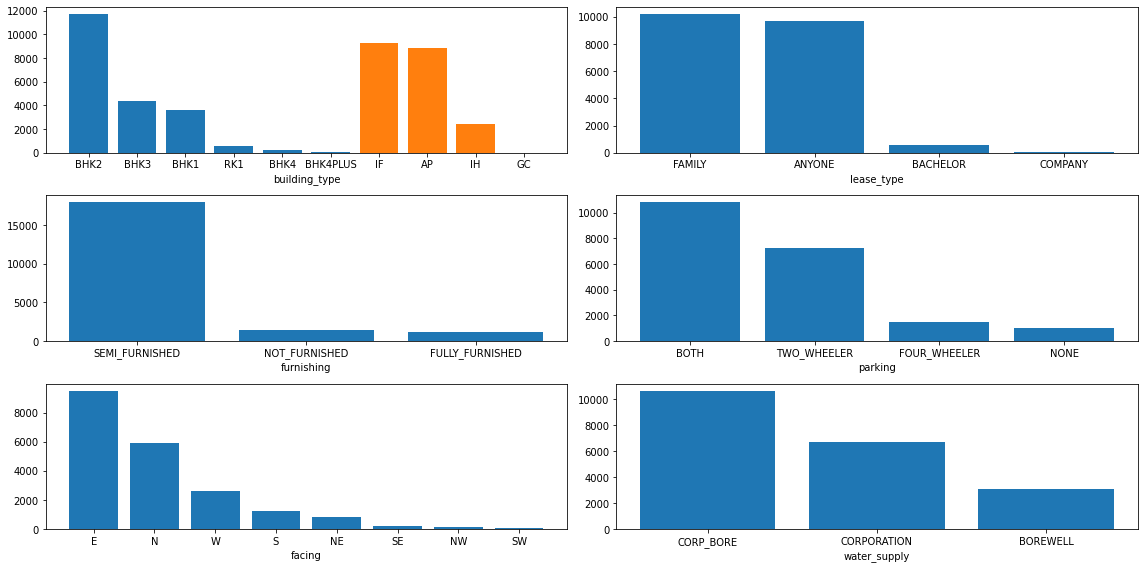

In [5]:
catCols = trainDf.dtypes[trainDf.dtypes == 'object'].index
fig = plt.figure(figsize=(16, 8))
for i, col in enumerate(catCols):
    counts = trainDf[col].value_counts()
    
    plt.subplot(3, 2, i%6 +1)
    
    plt.bar(counts.index, counts.values)
    plt.xlabel(col)

fig.tight_layout()

## Numerical values

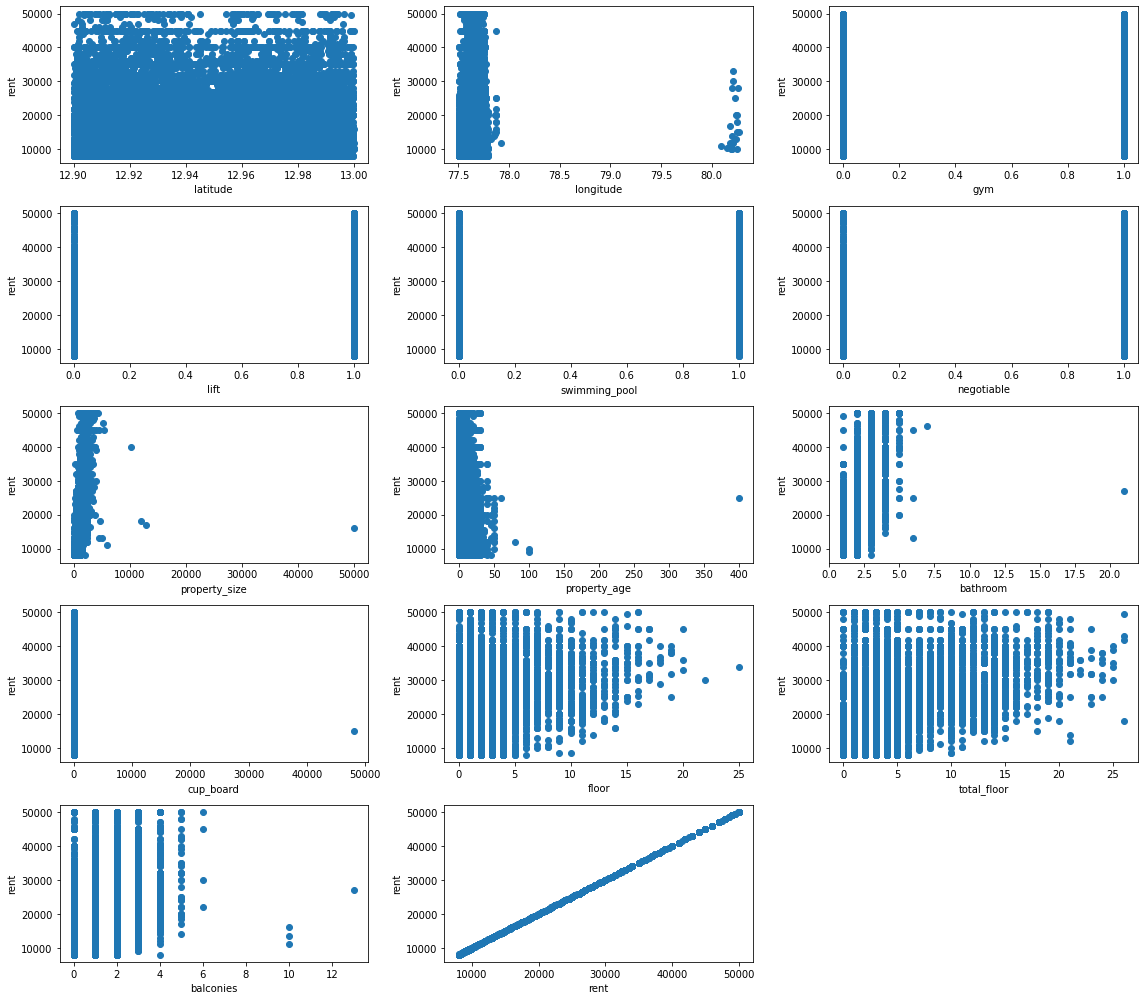

In [6]:
numCols = trainDf.dtypes[trainDf.dtypes != 'object'].index

fig = plt.figure(figsize=(16, 14))
for i, col in enumerate(numCols):
    plt.subplot(5, 3, i%15 +1)
    
    plt.scatter(trainDf[col].values, trainDf['rent'])
    plt.xlabel(col)
    plt.ylabel("rent")

fig.tight_layout()

## AMENITIES

In [7]:
amenitesCols = json.loads(trainDf_amenities.values[0]).keys()

for col in amenitesCols:
    trainDf[col] = trainDf_amenities.apply(lambda x: int(bool(json.loads(x).get(col))))

In [8]:
pca = PCA(n_components=1)
pca.fit(trainDf[amenitesCols])

trainDf["reducedAmenities"] = pca.transform(trainDf[amenitesCols]).reshape(-1, )

## Removing Outliers

**From the above plots the outliers are identified and that data instances is removed from training**

In [9]:
trainDf = trainDf[trainDf["property_size"]<5000]
trainDf = trainDf[trainDf["property_age"]<60]
trainDf = trainDf[trainDf["bathroom"]<7] 
trainDf = trainDf[trainDf["cup_board"]<25] 
trainDf = trainDf[trainDf["balconies"]<10] 

trainDf = trainDf[trainDf['property_age'] >0]

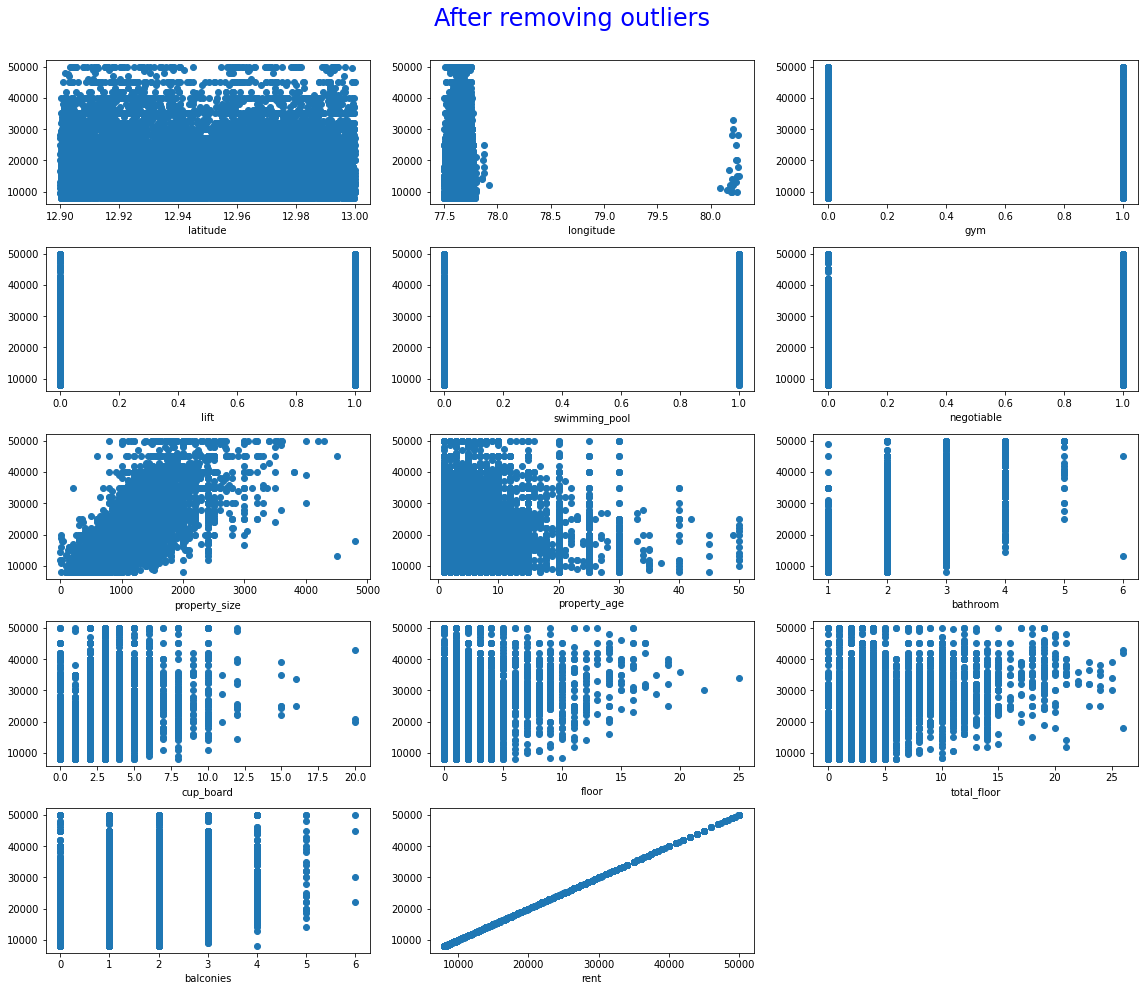

In [10]:
fig = plt.figure(figsize=(16, 14))
fig.suptitle('After removing outliers\n', fontsize=24, color='blue')
for i, col in enumerate(numCols):
    plt.subplot(5, 3, i%15 +1)
    
    plt.scatter(trainDf[col].values, trainDf['rent'])
    plt.xlabel(col)

fig.tight_layout()

## Feature Engineering

In [11]:
newCols = ["latitudeXlongitude",
           "totalSpace",
          "property_size/bathroom", "property_size/balconies", "property_size/cup_board",
          "total_floor/bathroom", "total_floor/balconies", "total_floor/cup_board",
          ]

# Features with lat and long
trainDf["latitudeXlongitude"] = trainDf.latitude * trainDf.longitude


# Total totalSpace in house
trainDf['totalSpace'] = trainDf.total_floor * trainDf.property_size


# Ratio of [bathroom, balconies, cup_board] with property_size
trainDf["property_size/bathroom"] = trainDf.property_size / trainDf.bathroom
trainDf["property_size/balconies"] = trainDf.property_size / trainDf.balconies
trainDf["property_size/cup_board"] = trainDf.property_size / trainDf.cup_board

# Ratio of [bathroom, balconies, cup_board] with total_floor
trainDf["total_floor/bathroom"] = trainDf.total_floor / trainDf.bathroom
trainDf["total_floor/balconies"] = trainDf.total_floor / trainDf.balconies
trainDf["total_floor/cup_board"] = trainDf.total_floor / trainDf.cup_board

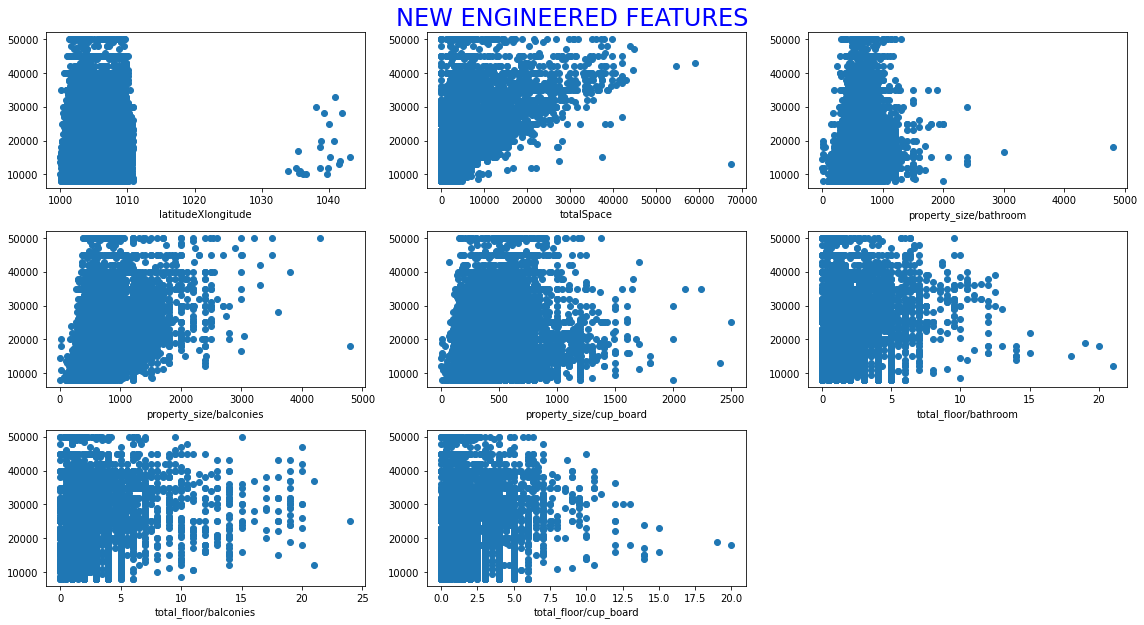

In [12]:
fig = plt.figure(figsize=(16, 14))
fig.suptitle('NEW ENGINEERED FEATURES', fontsize=24, color='blue')
for i, col in enumerate(newCols):
    plt.subplot(5, 3, i%15 +1)
    
    plt.scatter(trainDf[col].values, trainDf['rent'])
    plt.xlabel(col)

fig.tight_layout()

# PRE-PROCESSING

## Categorical to Numerical

In [13]:
cat2num = {}

for col in catCols:
    cat2num[f"{col}"] = {k: v+1 for v, k in enumerate(trainDf[col].unique())}

In [14]:
for col in catCols:
    trainDf[col].replace(cat2num[col], inplace=True)

**The infity values are created during feature engineering. <br> They are replace with 0**

In [15]:
trainDf.replace([np.inf, -np.inf], np.nan, inplace=True)
trainDf.fillna(0, inplace=True)

## Data Normalization

In [16]:
cols2Scale = newCols + ['latitude', 'longitude', 'property_size', 'property_age', 'cup_board', 'floor','total_floor']

scaler = RobustScaler()

In [17]:
scaler.fit(trainDf[cols2Scale])
trainDf[cols2Scale] = scaler.transform(trainDf[cols2Scale])

## Saving the preprocessed data

In [18]:
trainDf.to_csv("./dataset/processedTrain.csv", index=False)